## Classificateur Softmax superficiel avec epsilon = 0.25

Epoch [1/20], Loss: 0.3587071828282019
Epoch [2/20], Loss: 0.30677901797775015
Epoch [3/20], Loss: 0.3030715127215425
Epoch [4/20], Loss: 0.29414061782980905
Epoch [5/20], Loss: 0.28929743388576357
Epoch [6/20], Loss: 0.2936288654081412
Epoch [7/20], Loss: 0.28814769088864517
Epoch [8/20], Loss: 0.2870423907696057
Epoch [9/20], Loss: 0.28347664344896956
Epoch [10/20], Loss: 0.2852281049660433
Epoch [11/20], Loss: 0.2829664480616289
Epoch [12/20], Loss: 0.282386988333897
Epoch [13/20], Loss: 0.282051395942598
Epoch [14/20], Loss: 0.2800754453184635
Epoch [15/20], Loss: 0.28015095360878944
Epoch [16/20], Loss: 0.2799984830350224
Epoch [17/20], Loss: 0.28023346304607544
Epoch [18/20], Loss: 0.27876302600701225
Epoch [19/20], Loss: 0.2777435763586146
Epoch [20/20], Loss: 0.27912240259762383
Accuracy on adversarial examples: 0.0%
Average probability assigned to incorrect predictions: 98.97%


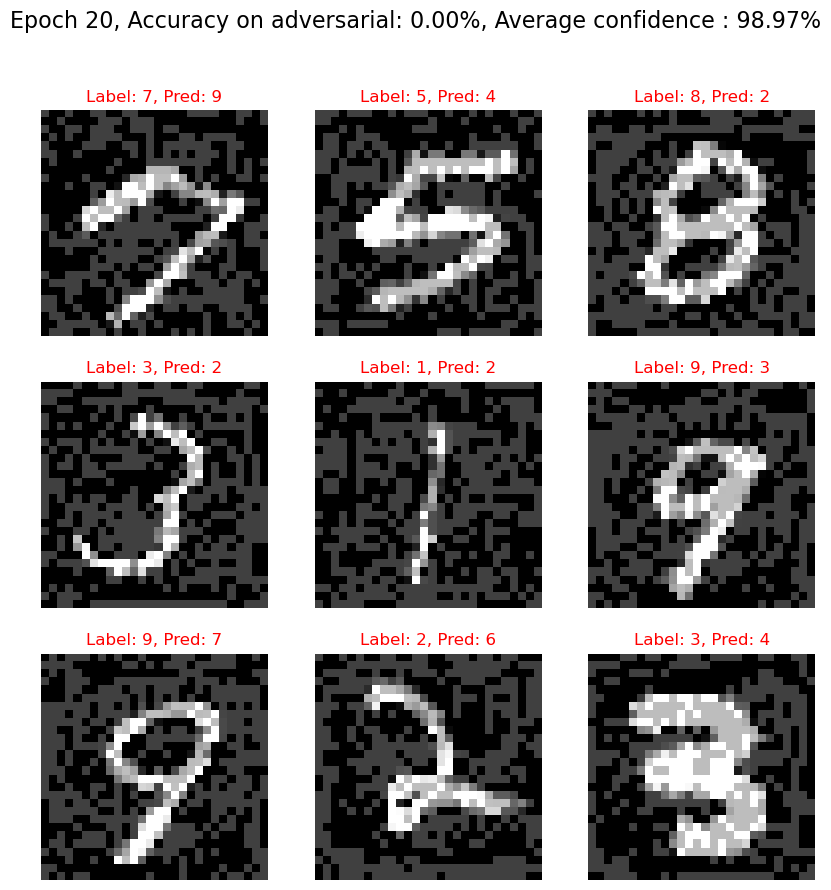

In [ ]:
# @title bonne version, Shallow Softmax Classifier avec epsilon = 0.25, et optimisateur : Adam
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  

    return adversarial_images

# Classe du modèle (shallow softmax classifier)
class ShallowSoftmaxClassifier(nn.Module):
    def __init__(self):
        super(ShallowSoftmaxClassifier, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)  

    def forward(self, x):
        x = x.view(-1, 28 * 28)  
        x = self.fc(x)
        return x  
    
# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()  

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        images = images.clone().detach().requires_grad_(True)

        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  
                incorrect_probs.append(probs[i, predicted[i]].item())

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs)*100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    train_loader = load_data()

    model = ShallowSoftmaxClassifier()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train_on_normal_data(model, train_loader, optimizer, epochs)

    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 0.48285688898329543
Epoch [2/20], Loss: 0.33701378400169457
Epoch [3/20], Loss: 0.31385348415546327
Epoch [4/20], Loss: 0.3023554575579888
Epoch [5/20], Loss: 0.2942320279745278
Epoch [6/20], Loss: 0.2887308493272455
Epoch [7/20], Loss: 0.28452451554919356
Epoch [8/20], Loss: 0.2803739167289185
Epoch [9/20], Loss: 0.27792397592621826
Epoch [10/20], Loss: 0.2752891561862375
Epoch [11/20], Loss: 0.2735934865071194
Epoch [12/20], Loss: 0.2712697515577904
Epoch [13/20], Loss: 0.2700490083362756
Epoch [14/20], Loss: 0.2684383188991913
Epoch [15/20], Loss: 0.2673752269884353
Epoch [16/20], Loss: 0.2656619415195512
Epoch [17/20], Loss: 0.2645417346771973
Epoch [18/20], Loss: 0.2635950752571702
Epoch [19/20], Loss: 0.2626389383411865
Epoch [20/20], Loss: 0.26184561158389424
Accuracy on adversarial examples: 0.011666666666666667%
Average probability assigned to incorrect predictions: 90.55%


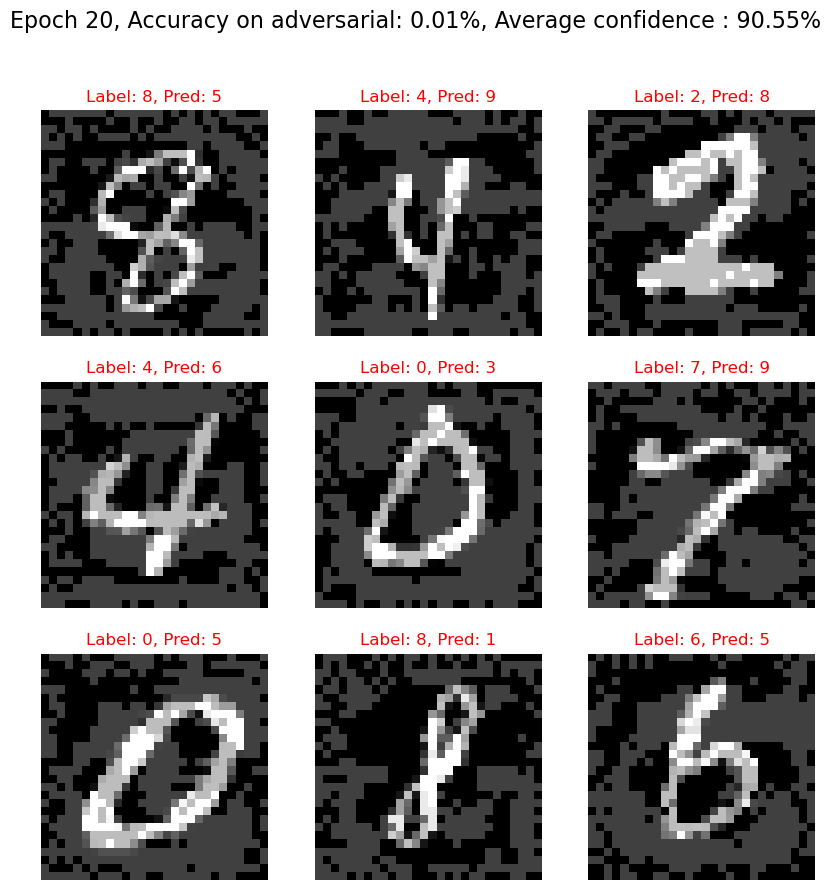

In [ ]:
# @title bonne version, Shallow Softmax Classifier avec epsilon = 0.25, et optimisateur : SGD avec momentum (=0.9)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Classe du modèle (shallow softmax classifier)
class ShallowSoftmaxClassifier(nn.Module):
    def __init__(self):
        super(ShallowSoftmaxClassifier, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc(x)
        return x
    
# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()

    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        images = images.clone().detach().requires_grad_(True)

        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:
                incorrect_probs.append(probs[i, predicted[i]].item())

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs)*100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    train_loader = load_data()

    model = ShallowSoftmaxClassifier()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_on_normal_data(model, train_loader, optimizer, epochs)

    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, train_loader, epsilon)

    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()
